#**Customer Churn Model**

Customer churn is a major problem and one of the most important concerns for large companies. Due to the direct effect on the revenues of the companies, especially in the telecom field, companies are seeking to develop means to predict potential customer to churn. Therefore, finding factors that increase customer churn is important to take necessary actions to reduce this churn. The main contribution of this work is to develop a churn prediction model which assists telecom operators to predict customers who are most likely subject to churn.


In [29]:
# Mounting the drive to import the files
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [30]:
# Importing the important librairies
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
import pickle

In [31]:
data = pd.read_excel('/content/drive/My Drive/Data_Science/datasets_13996_18858_WA_Fn-UseC_-Telco-Customer-Churn.xlsx')

In [32]:
data.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.50,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [33]:
data.dtypes

customerID           object
gender               object
SeniorCitizen         int64
Partner              object
Dependents           object
tenure                int64
PhoneService         object
MultipleLines        object
InternetService      object
OnlineSecurity       object
OnlineBackup         object
DeviceProtection     object
TechSupport          object
StreamingTV          object
StreamingMovies      object
Contract             object
PaperlessBilling     object
PaymentMethod        object
MonthlyCharges      float64
TotalCharges        float64
Churn                object
dtype: object

In [34]:
data.describe()

,SeniorCitizen,tenure,MonthlyCharges,TotalCharges
count,7043.000000,7043.000000,7043.000000,7032.000000
mean,0.162147,32.371149,64.761692,2283.300441
std,0.368612,24.559481,30.090047,2266.771362
min,0.000000,0.000000,18.250000,18.800000
25%,0.000000,9.000000,35.500000,401.450000
50%,0.000000,29.000000,70.350000,1397.475000
75%,0.000000,55.000000,89.850000,3794.737500
max,1.000000,72.000000,118.750000,8684.800000


In [35]:
data.isnull().sum()

customerID           0
gender               0
SeniorCitizen        0
Partner              0
Dependents           0
tenure               0
PhoneService         0
MultipleLines        0
InternetService      0
OnlineSecurity       0
OnlineBackup         0
DeviceProtection     0
TechSupport          0
StreamingTV          0
StreamingMovies      0
Contract             0
PaperlessBilling     0
PaymentMethod        0
MonthlyCharges       0
TotalCharges        11
Churn                0
dtype: int64

In [36]:
for i in data.columns.tolist():
  print(i)
  print(data[i].unique())
  print('-----------')

customerID
['7590-VHVEG' '5575-GNVDE' '3668-QPYBK' ... '4801-JZAZL' '8361-LTMKD'
 '3186-AJIEK']
-----------
gender
['Female' 'Male']
-----------
SeniorCitizen
[0 1]
-----------
Partner
['Yes' 'No']
-----------
Dependents
['No' 'Yes']
-----------
tenure
[ 1 34  2 45  8 22 10 28 62 13 16 58 49 25 69 52 71 21 12 30 47 72 17 27
  5 46 11 70 63 43 15 60 18 66  9  3 31 50 64 56  7 42 35 48 29 65 38 68
 32 55 37 36 41  6  4 33 67 23 57 61 14 20 53 40 59 24 44 19 54 51 26  0
 39]
-----------
PhoneService
['No' 'Yes']
-----------
MultipleLines
['No phone service' 'No' 'Yes']
-----------
InternetService
['DSL' 'Fiber optic' 'No']
-----------
OnlineSecurity
['No' 'Yes' 'No internet service']
-----------
OnlineBackup
['Yes' 'No' 'No internet service']
-----------
DeviceProtection
['No' 'Yes' 'No internet service']
-----------
TechSupport
['No' 'Yes' 'No internet service']
-----------
StreamingTV
['No' 'Yes' 'No internet service']
-----------
StreamingMovies
['No' 'Yes' 'No internet service']
-----

**Extracting the relevant features that can define a customer churn**

Looking at the dataset, the only column that we will drop is the customer ID, given that it does not affect if a customer churns or not

In [37]:
Selected_data = data.drop(['customerID'], axis = 1)

**mapping features show areas where customers churn a lot**

In [38]:
churn_data = Selected_data.copy()
churn_data = churn_data[churn_data['Churn'] == 'Yes']

In [39]:
churn_data.groupby(['InternetService'])['Churn'].count().reset_index()

,InternetService,Churn
0,DSL,459
1,Fiber optic,1297
2,No,113


**Applying Extreme Gradient Boosting “XGBOOST” model .**

Data preparation

In [40]:
# We start by replacing the 11 missing values in the TotalCharges
Selected_data['TotalCharges'].fillna(Selected_data['TotalCharges'].mean(), inplace=True)

In [41]:
Selected_data.isnull().sum()

gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64

In [42]:
def categories_convert(dataframe, columns_names):
  for i in columns_names:
    dataframe[i] = pd.get_dummies(dataframe[i]) 

In [43]:
columns_names = ["gender","Partner","Dependents","PhoneService","MultipleLines","OnlineSecurity","InternetService","OnlineBackup","DeviceProtection","TechSupport","StreamingTV","StreamingMovies","Contract","PaperlessBilling", "PaymentMethod","Churn"]
categories_convert(Selected_data, columns_names)

In [44]:
len(columns_names)

16

In [45]:
Selected_data

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,1,0,0,1,1,1,0,1,1,0,1,1,1,1,1,0,0,29.85,29.85,1
1,0,0,1,1,34,0,1,1,0,1,0,1,1,1,0,1,0,56.95,1889.50,1
2,0,0,1,1,2,0,1,1,0,0,1,1,1,1,1,0,0,53.85,108.15,0
3,0,0,1,1,45,1,0,1,0,1,0,0,1,1,0,1,1,42.30,1840.75,1
4,1,0,1,1,2,0,1,0,1,1,1,1,1,1,1,0,0,70.70,151.65,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,0,0,0,0,24,0,0,1,0,1,0,0,0,0,0,0,0,84.80,1990.50,1
7039,1,0,0,0,72,0,0,0,1,0,0,1,0,0,0,0,0,103.20,7362.90,1
7040,1,0,0,0,11,1,0,1,0,1,1,1,1,1,1,0,0,29.60,346.45,1
7041,0,1,0,1,4,0,0,0,1,1,1,1,1,1,1,0,0,74.40,306.60,0


In [46]:
Selected_data.shape

(7043, 20)

In [47]:
# Let's now normalize the the numerical values in the monthly charges, Tenure and Totalcharges columns
scaler = MinMaxScaler()
to_normalize = ['tenure', 'MonthlyCharges', 'TotalCharges']
Selected_data[to_normalize] = scaler.fit_transform(Selected_data[to_normalize])

In [48]:
Selected_data.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,1,0,0,1,0.013889,1,0,1,1,0,1,1,1,1,1,0,0,0.115423,0.001275,1
1,0,0,1,1,0.472222,0,1,1,0,1,0,1,1,1,0,1,0,0.385075,0.215867,1
2,0,0,1,1,0.027778,0,1,1,0,0,1,1,1,1,1,0,0,0.354229,0.010310,0
3,0,0,1,1,0.625000,1,0,1,0,1,0,0,1,1,0,1,1,0.239303,0.210241,1
4,1,0,1,1,0.027778,0,1,0,1,1,1,1,1,1,1,0,0,0.521891,0.015330,0


In [49]:
y = Selected_data['Churn']
X = Selected_data.drop(['Churn'] , axis = 1)

In [50]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

Preparing and training

In [51]:
# fit model no training data
model = XGBClassifier()
model.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

**Evaluate the model’s accuracy and calculate the AUC value.**

In [52]:
y_pred = model.predict(X_test)
predictions = [round(value) for value in y_pred]

In [53]:
# evaluate predictions
accuracy = accuracy_score(y_test, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 79.84%


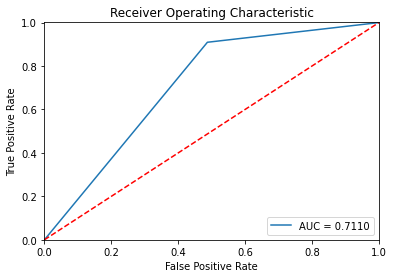

In [54]:
# Calculate the AUC
import matplotlib.pyplot as plt
from sklearn.metrics import (confusion_matrix, precision_recall_curve, auc,
                             roc_curve, recall_score, classification_report, f1_score,
                             precision_recall_fscore_support)

fpr, tpr, thresholds = roc_curve(y_test, predictions)
roc_auc = auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, label='AUC = %0.4f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.001, 1])
plt.ylim([0, 1.001])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show();

In [62]:
# Calculating the confidence factor
from math import sqrt
interval = 2.58 * sqrt( (accuracy * (1 - accuracy)) / y_test.shape[0])

In [ ]:
pickle.dump(model, open('classifier.pkl', 'wb'))

In [63]:
interval

0.027573293748408778